In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from fdm import derivative_matrix
from fdm_integrals import backward_euler_int, trapezoids_int
from numerical_integral import compute_integral
from rates import make_b, make_sigma2
from params import ex_params_1

In [3]:
b = make_b(ex_params_1)
sigma2 = make_sigma2(ex_params_1)

In [22]:
# Parametry dla rozwiązywania RRCz
n = 100                    # liczba kroków w przestrzeni
h = ex_params_1.n_star/n   # dł. kroku w przestrzeni
tau = 0.1                  # dł. kroku w czasie
tol = 10**-2               # tolerancja w całkowaniu funkcji u

# Dla numerycznego obliczania wartości oczekiwanej bierzemy mniejszy krok
int_step = h / 10
int_n = n * 10

In [23]:
# Obliczamy numerycznie wartość oczekiwaną
num_int_linspace, num_int = compute_integral(int_step, int_n, ex_params_1)

In [24]:
# Całkujemy w locie funkcje otrzymanie z rozwiązywania RRCz
d_m, special = derivative_matrix(b, sigma2, h, n)
u_0 = np.ones(n)
#int_u_euler = backward_euler_int(u_0, d_m, tau, tol)
#int_u_trapezoids = trapezoids_int(u_0, d_m, special, tau, tol)

In [6]:
pde_linspace = np.linspace(0, ex_params_1.n_star-h, len(int_u_euler))

NameError: name 'int_u_euler' is not defined

In [ ]:
# Sprawdzam które elementy w numerycznej wartości oczekiwanej
# i w całce z rozwiązania RRCz sobie odpowiadają
np.allclose(num_int_linspace[9::10][:-1], pde_linspace[1:])

In [25]:
# Przycinam wyniki
linspace = num_int_linspace[9::10][:-1]
num_int = num_int[9::10][:-1]
#int_u_euler = int_u_euler[1:]
#int_u_trapezoids = int_u_trapezoids[1:]

In [ ]:
plt.plot(linspace, int_u_euler)
#plt.plot(linspace, int_u_trapezoids)
plt.plot(linspace, num_int)
plt.legend(["Całka z backward Euler", "Numeryczna wartość oczekiwana"])

In [ ]:
np.mean((num_int-int_u_euler)**2)

In [26]:
from fem_integrals import backward_euler_fem_int, trapezoids_fem_int

In [27]:
int_u_fem_euler = backward_euler_fem_int(n, h, u_0, ex_params_1, tau, tol)[1:]

In [18]:
#int_u_fem_trapezoids = trapezoids_fem_int(n, h, u_0, ex_params_1, tau, tol)[1:]

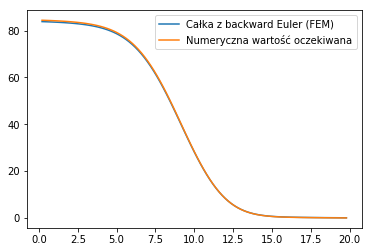

In [28]:
plt.plot(linspace, int_u_fem_euler)
plt.plot(linspace, num_int)
plt.legend(["Całka z backward Euler (FEM)", "Numeryczna wartość oczekiwana"])

## Liczenie rzędu zbieżności dla metody FEM

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from fdm import derivative_matrix
from fem_integrals import backward_euler_fem_int, trapezoids_fem_int
from numerical_integral import compute_integral
from rates import make_b, make_sigma2
from params import ex_params_1

In [3]:
b = make_b(ex_params_1)
sigma2 = make_sigma2(ex_params_1)

In [4]:
tol = 10**-5  # tolerancja w całkowaniu funkcji u

### Wsteczny Euler

In [29]:
# Liczba podziałów odcinka [0, 1]
kawalki = (20, 40, 80, 160, 320)
# Liczymy wartość oczekiwaną z dokładnością 10x większą niż największa liczba kawałków
big_n = int(ex_params_1.n_star * kawalki[-1])
small_h = ex_params_1.n_star / big_n
int_n = 10 * big_n
int_step = small_h / 10
num_int_linspace, num_int = compute_integral(int_step, int_n, ex_params_1)
bledy = np.empty((len(kawalki), len(kawalki)))
for i, kawalki_przestrzen in enumerate(kawalki):
    for j, kawalki_czas in enumerate(kawalki):
        n = int(ex_params_1.n_star * kawalki_przestrzen)
        h = ex_params_1.n_star / n
        tau = 1 / kawalki_czas
        u_0 = np.ones(n)
        int_u_euler = backward_euler_fem_int(n, h, u_0, ex_params_1, tau, tol)[1:]
        pde_linspace = np.linspace(0, ex_params_1.n_star-h, len(int_u_euler)+1)[1:]  # +1 bo obcięliśmy linijkę wyżej

        # Wycinanie odpowiednich wartości z E
        obetnij_pierwsze = int(int_n/n) - 1
        bierz_co = int(int_n/n)
        linspace = num_int_linspace[obetnij_pierwsze::bierz_co][:-1]
        assert np.allclose(pde_linspace, linspace)  # sprawdzamy czy wszystko OK
        
        bledy[i,j] = np.mean(np.abs(num_int[obetnij_pierwsze::bierz_co][:-1]-int_u_euler))

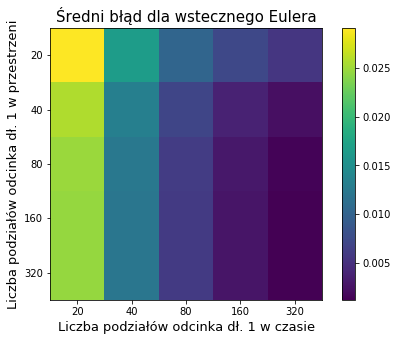

In [76]:
plt.figure(figsize=(7, 5))
plt.imshow(bledy)
plt.colorbar()
plt.title("Średni błąd dla wstecznego Eulera", fontsize=15)
plt.xticks(range(len(kawalki)), kawalki)
plt.yticks(range(len(kawalki)), kawalki)
plt.xlabel("Liczba podziałów odcinka dł. 1 w czasie", fontsize=13)
plt.ylabel("Liczba podziałów odcinka dł. 1 w przestrzeni", fontsize=13);

### Rząd zbieżności dla wstecznego Eulera

##### po czasie

In [41]:
rzedy_czas = np.log2(bledy[:,:-1] / bledy[:,1:])

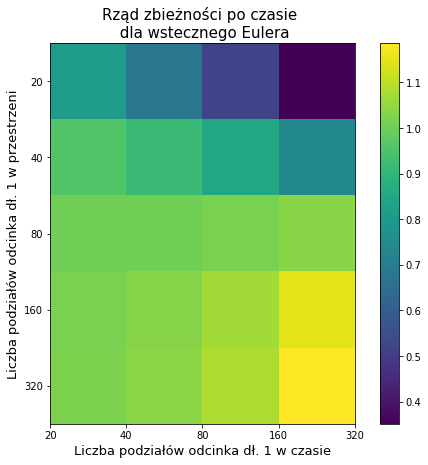

In [64]:
plt.figure(figsize=(9, 7))
plt.imshow(rzedy_czas)
plt.colorbar()
plt.title("Rząd zbieżności po czasie \n dla wstecznego Eulera", fontsize=15)
plt.xticks(np.arange(len(kawalki)) - 0.5, kawalki)
plt.yticks(range(len(kawalki)), kawalki)
plt.xlabel("Liczba podziałów odcinka dł. 1 w czasie", fontsize=13)
plt.ylabel("Liczba podziałów odcinka dł. 1 w przestrzeni", fontsize=13);

##### po przestrzeni

In [47]:
rzedy_przestrzen = np.log2(bledy[:-1,:] / bledy[1:,:])

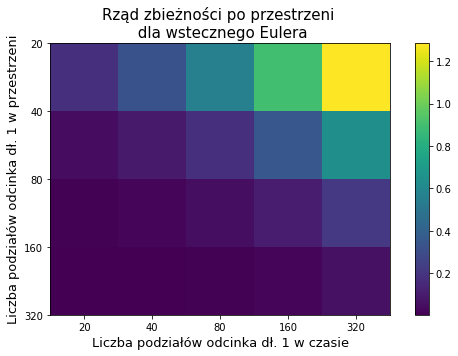

In [59]:
plt.figure(figsize=(9, 5))
plt.imshow(rzedy_przestrzen)
plt.colorbar()
plt.title("Rząd zbieżności po przestrzeni \n dla wstecznego Eulera", fontsize=15)
plt.xticks(range(len(kawalki)), kawalki)
plt.yticks(np.arange(len(kawalki)) - 0.5, kawalki)
plt.xlabel("Liczba podziałów odcinka dł. 1 w czasie", fontsize=13)
plt.ylabel("Liczba podziałów odcinka dł. 1 w przestrzeni", fontsize=13);

### Trapezy

In [ ]:
# Liczba podziałów odcinka [0, 1]
kawalki = (20, 40, 80, 160, 320)
# Liczymy wartość oczekiwaną z dokładnością 10x większą niż największa liczba kawałków
big_n = int(ex_params_1.n_star * kawalki[-1])
small_h = ex_params_1.n_star / big_n
int_n = 10 * big_n
int_step = small_h / 10
num_int_linspace, num_int = compute_integral(int_step, int_n, ex_params_1)
bledy_tr = np.empty((len(kawalki), len(kawalki)))
for i, kawalki_przestrzen in enumerate(kawalki):
    for j, kawalki_czas in enumerate(kawalki):
        n = int(ex_params_1.n_star * kawalki_przestrzen)
        h = ex_params_1.n_star / n
        tau = 1 / kawalki_czas
        u_0 = np.ones(n)
        int_u_euler = trapezoids_fem_int(n, h, u_0, ex_params_1, tau, tol)[1:]
        pde_linspace = np.linspace(0, ex_params_1.n_star-h, len(int_u_euler)+1)[1:]  # +1 bo obcięliśmy linijkę wyżej

        # Wycinanie odpowiednich wartości z E
        obetnij_pierwsze = int(int_n/n) - 1
        bierz_co = int(int_n/n)
        linspace = num_int_linspace[obetnij_pierwsze::bierz_co][:-1]
        assert np.allclose(pde_linspace, linspace)  # sprawdzamy czy wszystko OK
        
        bledy_tr[i,j] = np.mean(np.abs(num_int[obetnij_pierwsze::bierz_co][:-1]-int_u_euler))

Zakończono całkowanie w momencie 927.85, po 18557 iteracji.
Zakończono całkowanie w momencie 927.8000000000001, po 37112 iteracji.
Zakończono całkowanie w momencie 927.7750000000001, po 74222 iteracji.
Zakończono całkowanie w momencie 927.7687500000001, po 148443 iteracji.
Zakończono całkowanie w momencie 927.7625, po 296884 iteracji.
Zakończono całkowanie w momencie 927.75, po 18555 iteracji.
Zakończono całkowanie w momencie 927.7, po 37108 iteracji.
Zakończono całkowanie w momencie 927.6875, po 74215 iteracji.
Zakończono całkowanie w momencie 927.6812500000001, po 148429 iteracji.
Zakończono całkowanie w momencie 927.6750000000001, po 296856 iteracji.
Zakończono całkowanie w momencie 3698.3, po 73966 iteracji.
Zakończono całkowanie w momencie 927.6750000000001, po 37107 iteracji.
Zakończono całkowanie w momencie 927.6625, po 74213 iteracji.
Zakończono całkowanie w momencie 927.65625, po 148425 iteracji.
Zakończono całkowanie w momencie 927.653125, po 296849 iteracji.
Zakończono całko

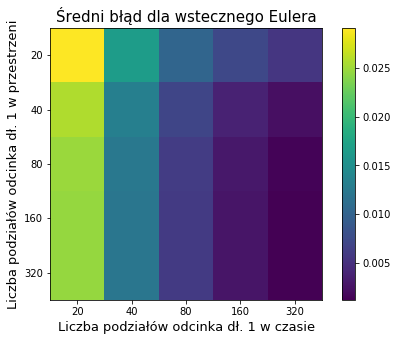

In [76]:
plt.figure(figsize=(7, 5))
plt.imshow(bledy_tr)
plt.colorbar()
plt.title("Średni błąd dla trapezów", fontsize=15)
plt.xticks(range(len(kawalki)), kawalki)
plt.yticks(range(len(kawalki)), kawalki)
plt.xlabel("Liczba podziałów odcinka dł. 1 w czasie", fontsize=13)
plt.ylabel("Liczba podziałów odcinka dł. 1 w przestrzeni", fontsize=13);

### Rząd zbieżności dla trapezów

##### Rząd zbieżności dla trapezów po czasie

In [41]:
rzedy_czas = np.log2(bledy_tr[:,:-1] / bledy_tr[:,1:])

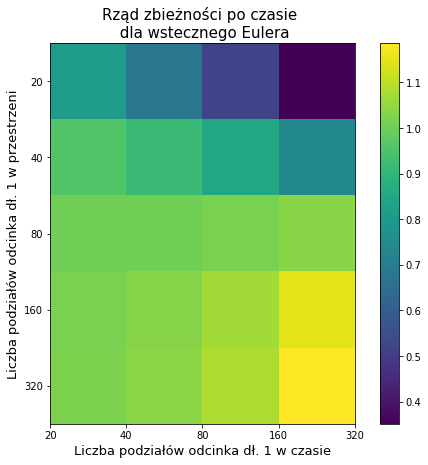

In [64]:
plt.figure(figsize=(9, 7))
plt.imshow(rzedy_czas)
plt.colorbar()
plt.title("Rząd zbieżności po czasie \n dla schematu trapezów", fontsize=15)
plt.xticks(np.arange(len(kawalki)) - 0.5, kawalki)
plt.yticks(range(len(kawalki)), kawalki)
plt.xlabel("Liczba podziałów odcinka dł. 1 w czasie", fontsize=13)
plt.ylabel("Liczba podziałów odcinka dł. 1 w przestrzeni", fontsize=13);

##### Rząd zbieżności dla trapezów po przestrzeni

In [47]:
rzedy_przestrzen = np.log2(bledy_tr[:-1,:] / bledy_tr[1:,:])

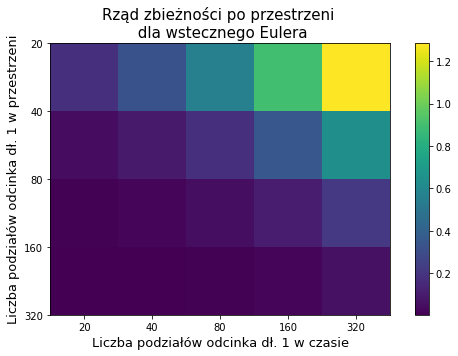

In [59]:
plt.figure(figsize=(9, 5))
plt.imshow(rzedy_przestrzen)
plt.colorbar()
plt.title("Rząd zbieżności po przestrzeni \n dla schematu trapezów", fontsize=15)
plt.xticks(range(len(kawalki)), kawalki)
plt.yticks(np.arange(len(kawalki)) - 0.5, kawalki)
plt.xlabel("Liczba podziałów odcinka dł. 1 w czasie", fontsize=13)
plt.ylabel("Liczba podziałów odcinka dł. 1 w przestrzeni", fontsize=13);

Czas kwadratowo zależny od przestrzeni (nie odpalałem):

In [ ]:
# Liczba podziałów odcinka [0, 1]
kawalki_kw = (5, 10, 20)
# Liczymy wartość oczekiwaną z dokładnością 10x większą niż największa liczba kawałków
big_n = int(ex_params_1.n_star * kawalki[-1])
small_h = ex_params_1.n_star / big_n
int_n = 10 * big_n
int_step = small_h / 10
num_int_linspace, num_int = compute_integral(int_step, int_n, ex_params_1)
bledy_kw = np.empty(len(kawalki))
for i, kawalki_przestrzen in enumerate(kawalki):
    kawalki_czas = kawalki_przestrzen**2
    n = int(ex_params_1.n_star * kawalki_przestrzen)
    h = ex_params_1.n_star / n
    tau = 1 / kawalki_czas
    u_0 = np.ones(n)
    int_u_euler = backward_euler_fem_int(n, h, u_0, ex_params_1, tau, tol)[1:]
    pde_linspace = np.linspace(0, ex_params_1.n_star-h, len(int_u_euler)+1)[1:]  # +1 bo obcięliśmy linijkę wyżej

    # Wycinanie odpowiednich wartości z E
    obetnij_pierwsze = int(int_n/n) - 1
    bierz_co = int(int_n/n)
    linspace = num_int_linspace[obetnij_pierwsze::bierz_co][:-1]
    assert np.allclose(pde_linspace, linspace)  # sprawdzamy czy wszystko OK

    bledy_kw[i] = np.mean(np.abs(num_int[obetnij_pierwsze::bierz_co][:-1]-int_u_euler))

# Przykładowe wyniki dla FDM

In [ ]:
from fdm import derivative_matrix, backward_euler, trapezoids
n = 100
h = ex_params_1.n_star/n
m = 5000
width = 50
tau = width/m
d_m, special = derivative_matrix(b, sigma2, h, n)
import numpy as np
u_0 = np.ones(n)
u_beul = backward_euler(u_0, d_m, tau, m)
u_trapz = trapezoids(u_0, d_m, special, tau, m)
extent=[0, width, 0, 20]

In [ ]:
plt.figure(figsize=(13, 5))
plt.imshow(u_beul.T, origin="low", extent=extent)
plt.colorbar()
plt.title("Wykres dla FDM (wsteczny Euler)", fontsize=15)
plt.xlabel("czas", fontsize=13)
plt.ylabel("liczba wiązań", fontsize=13);

In [ ]:
plt.figure(figsize=(13, 5))
plt.imshow(u_trapz.T, origin="low", extent=extent)
plt.colorbar()
plt.title("Wykres dla FDM (schemat trapezów)", fontsize=15)
plt.xlabel("czas", fontsize=13)
plt.ylabel("liczba wiązań", fontsize=13);